# Modelo de Aprendizado de Máquina não supervisionado utilizando K-means para clusterizar os milímetros de pluviosidade registrados nos últimos 24 anos na cidade do Rio de Janeiro

Instalando Bibliotecas

In [ ]:
pip install openmeteo-requests

In [ ]:
pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Importando Bibliotecas

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

Código utilizado para acesso à API: [Open-Meteo](https://open-meteo.com/en/docs/historical-weather-api#latitude=-22.9064&longitude=-43.1822&start_date=2000-01-01&end_date=2024-08-24&hourly=&daily=rain_sum&timezone=America%2FSao_Paulo)

In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": -22.9064,
	"longitude": -43.1822,
	"start_date": "2000-01-01",
	"end_date": "2024-08-24",
	"daily": "rain_sum",
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
response.Latitude()
response.Longitude()
response.Elevation()
response.Timezone()
response.TimezoneAbbreviation()
response.UtcOffsetSeconds()

daily = response.Daily()
daily_rain_sum = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)

## Análise Exploratória dos Dados


In [ ]:
daily_dataframe.head()

,date,rain_sum
0,2000-01-01 03:00:00+00:00,15.400001
1,2000-01-02 03:00:00+00:00,69.500000
2,2000-01-03 03:00:00+00:00,28.199997
3,2000-01-04 03:00:00+00:00,0.000000
4,2000-01-05 03:00:00+00:00,0.100000


In [ ]:
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9003 entries, 0 to 9002
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rain_sum  9003 non-null   float64
dtypes: float64(1)
memory usage: 70.5 KB


In [ ]:
daily_dataframe.describe()

,rain_sum
count,9003.000000
mean,2.967056
std,7.008090
min,0.000000
25%,0.000000
50%,0.200000
75%,2.600000
max,149.200012


## Pré Processamento

In [ ]:
# Retirando linha nulas

nan = daily_dataframe[pd.isna(daily_dataframe['rain_sum'])].index
daily_dataframe = daily_dataframe.drop(nan)

In [ ]:
# Editando coluna rain_sum para 2 digitos depois da vírgula

daily_dataframe['rain_sum'] = daily_dataframe['rain_sum'].apply(lambda x: '{:.0f}'.format(x))

In [ ]:
# Alterando datatype para float

daily_dataframe['rain_sum'] = daily_dataframe['rain_sum'].astype(float)

In [ ]:
# Retirando coluna date

daily_dataframe = daily_dataframe.drop('date', axis=1)

Normalizando os dados

In [ ]:
mm = MinMaxScaler()

daily_dataframe_mm = mm.fit_transform(daily_dataframe[['rain_sum']])

## Modelo

Métodos Cotovelo e Silhueta

In [ ]:
range_n_clusters = list(range(2, 10))


for n_clusters in range_n_clusters:

    cluster = KMeans(n_clusters=n_clusters)
    preds = cluster.fit_predict(daily_dataframe_mm)
    centers = cluster.cluster_centers_

    score = silhouette_score(daily_dataframe_mm, preds)
    print("Número de clusters: {}, silhouette score: {})".format(n_clusters, score))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 2, silhouette score: 0.8527473339101944)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 3, silhouette score: 0.8187481915012986)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 4, silhouette score: 0.7919633534467796)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 5, silhouette score: 0.7821762438385589)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 6, silhouette score: 0.7693874830812205)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 7, silhouette score: 0.7670518366569331)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 8, silhouette score: 0.7740682615358624)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters: 9, silhouette score: 0.7739312186730001)


In [ ]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

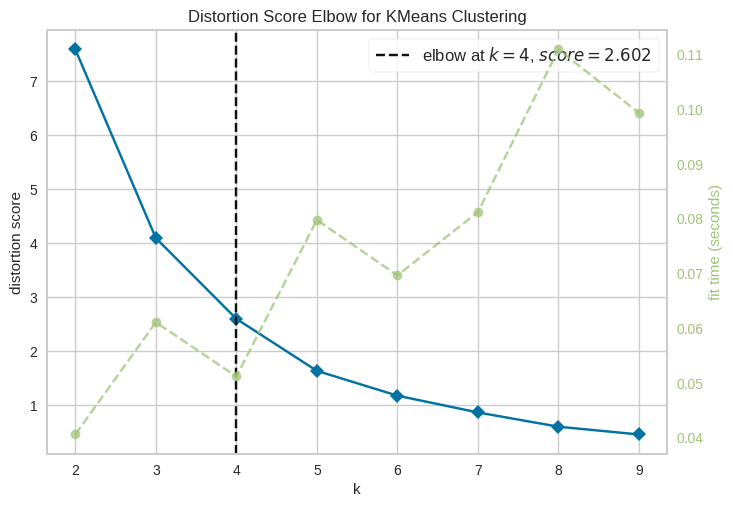

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(random_state=26)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(daily_dataframe_mm)
visualizer.show()

Kmeans

In [ ]:
model = KMeans(n_clusters = 4, init = 'k-means++', random_state =  26)

x = daily_dataframe_mm
model.fit(x)

y = model.predict(x)
y

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 3, 0, ..., 1, 1, 1], dtype=int32)

## Análise dos Clusters

Clusters

In [ ]:
# Inserindo coluna com clusters no dataframe

daily_dataframe['K_Cluster'] = model.labels_
daily_dataframe.head()

,rain_sum,K_Cluster
0,15.0,2
1,70.0,3
2,28.0,0
3,0.0,1
4,0.0,1


In [ ]:
daily_dataframe['K_Cluster'].value_counts()

,count
K_Cluster,
1,7404
2,1150
0,378
3,71


In [ ]:
def df_values(df):

    df_new = df.groupby(['K_Cluster']).agg({'rain_sum': ['min', 'max', 'mean', 'median', 'count']}).round(0)

    df_new.columns = ['RainMin', 'RainMax', 'RainMean', 'RainMedian', 'RainCount']

    return df_new

In [ ]:
# Analise das medidas de tendencia central dos clusters

medias = df_values(daily_dataframe)
medias

,RainMin,RainMax,RainMean,RainMedian,RainCount
K_Cluster,,,,,
0,16.0,37.0,22.0,21.0,378
1,0.0,4.0,1.0,0.0,7404
2,5.0,15.0,9.0,8.0,1150
3,38.0,149.0,52.0,45.0,71


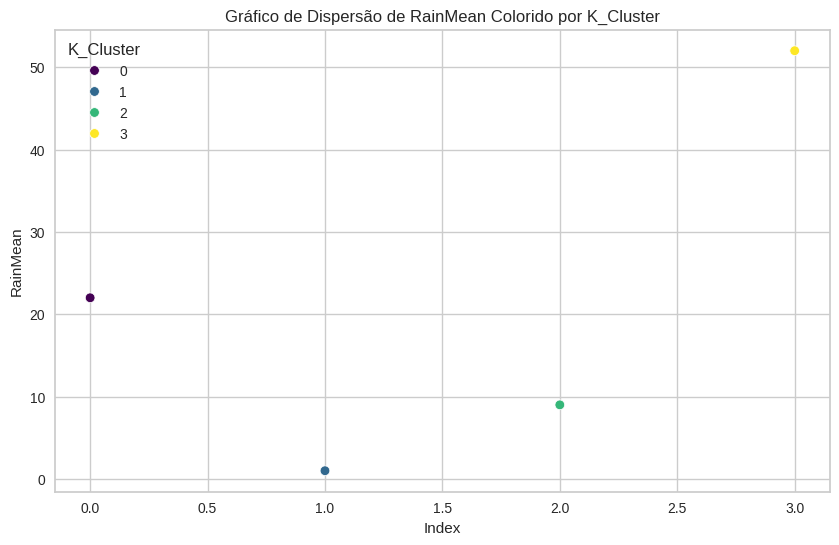

In [ ]:
# Visualização

plt.figure(figsize=(10, 6))
sns.scatterplot(data=medias, x=medias.index, y='RainMean', hue='K_Cluster', palette='viridis')

plt.title('Gráfico de Dispersão de RainMean Colorido por K_Cluster')
plt.xlabel('Index')
plt.ylabel('RainMean')
plt.legend(title='K_Cluster')
plt.show()

## Conslusão

Os métodos do cotovelo e da silhueta indicaram que 4 é a quantidade ideal de clusters para este conjunto de dados. Usando o K-means, identificamos as seguintes categorias:


 - Cluster 0: entre **16,0 mm e 37,0 mm** de pluviosidade, com **378** registros.

 - Cluster 1: entre **0,0 mm e 4,0 mm** de pluviosidade, com **7.404** registros.

 - Cluster 2: entre **5,0 mm e 15,0 mm** de pluviosidade, com **1.150** registros.

 - Cluster 3: entre **38,0 mm e 149,0** mm de pluviosidade, com **71** registros.


Podemos observar que a maior parte dos registros de pluviosidade na cidade do Rio de Janeiro se concentra em valores muito baixos. O Cluster 1, que cobre pluviosidade entre 0,0 mm e 4,0 mm, tem a maioria dos registros (7.404), o que indica que a cidade experimenta períodos de chuva leve ou quase inexistente com muita frequência.

Os Clusters 2 e 0, que cobrem faixas de pluviosidade um pouco mais elevadas (5,0 mm a 15,0 mm e 16,0 mm a 37,0 mm, respectivamente), possuem menos registros (1.150 e 378), sugerindo que chuvas moderadas são menos comuns. O Cluster 3, que representa os eventos de chuva mais intensa (38,0 mm a 149,0 mm), é o menos frequente, com apenas 71 registros.

Esses resultados sugerem que, embora chuvas intensas sejam relativamente raras, a cidade enfrenta predominantemente períodos de pouca chuva, com episódios ocasionais de precipitação moderada a intensa. Esse padrão pode influenciar tanto o planejamento urbano quanto a alocação de recursos para mitigar impactos de eventos de chuva intensa.